<center><img src="img/logo_hse.png" width="1000"></center>

<h1><center>Прикладные задачи анализа данных</center></h1>
<h2><center>Домашнее задание 1: Генеративные сети</center></h2>

# Введение

Не все же нам MNIST генерировать. Давайте посмотрим, как генеративные модели могут использоваться не только для развлечения. Поехали!

Немного вступления и мотивации, для чего мы хотим обучать модель.

## MAGIC – Major Atmospheric Gamma Imaging Cherenkov Telescope

MAGIC (Major Atmospheric Gamma Imaging Cherenkov) - это система, состоящая из двух черенковских телескопов диаметром 17 м. Они предназначены для наблюдения гамма-лучей от галактических и внегалактических источников в диапазоне очень высоких энергий (от 30 ГэВ до 100 ТэВ). 

MAGIC позволил открыть и исследовать новые классы источников гамма-излучения, таких как, например, пульсары и гамма-всплески (GRB).

<center><img src="img/magic1.jpg" width="1000"></center>

Источник: https://magic.mpp.mpg.de/

Youtube video: https://youtu.be/mjcDSR2vSU8

#### Ок, давайте зафиксируем. Какой-то крутой телескоп позволяет открыть новые виды излучения. Идем дальше.

## Частицы из космоса

Космические частицы, $\gamma$-кванты (фотоны) и адроны (протоны), взаимодействуют с атмосферой и порождают ливни вторичных частиц. Двигаясь с околосветовой скоростью, эти частицы излучают Черенковское излучение. Телескопы фотографируют это излучение. 
#### По фотографиям можно определить тип частицы из космоса: фотон или протон. Знакомая формулировка задачи, не правда ли?

<center><img src="img/shower.jpg" width="500"></center>

## Фотографии

Задача атмосферного черенковского телескопа - получить изображение ливня путем измерения черенковского света от частиц ливня. Это изображение представляет собой геометрическую проекцию ливня на детектор. Для анализа этих изображений были введены параметры изображения или так называемые параметры Хилласа. Ниже пример такой фотографии.

<center><img src="img/geo.jpg" width="400"></center>

#### Итак, каждая фотография описывается набором параметров, которые за нас считает телесоп. А что там с двумя видами частиц?

## Фотоны vs адронов

Изображения для $\gamma$-квантов (фотонов) и адронов (протонов) отличаются по форме кластеров. Астрономы используют модели машинного обучения для классификации этих изображений. Получение каждого такого изображения - дорогое удовольствие!


<center><img src="img/gamma_p.png" width="600"></center>

Для обучения моделей ученые искусственно генерируют такие изображения для каждого типа частиц с помощью сложных физических симуляторов. 

#### Итак, давайте сэкономим денег для ученых и сгенерируем хороших фотографий разных частиц. Используем для этого GAN и диффузионные модели!

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Данные

Будем использовать данные телескопа MAGIC из UCI репозитория https://archive.ics.uci.edu/ml/datasets/MAGIC+Gamma+Telescope. Каждый объект в данных - параметры одного изображения кластера и метка этого кластера (фотон или адрон):


0. Length: major axis of ellipse [mm]
1. Width: minor axis of ellipse [mm]
2. Size: 10-log of sum of content of all pixels [in #phot]
3. Conc: ratio of sum of two highest pixels over fSize [ratio]
4. Conc1: ratio of highest pixel over fSize [ratio]
5. Asym: distance from highest pixel to center, projected onto major axis [mm]
6. M3Long: 3rd root of third moment along major axis [mm]
7. M3Trans: 3rd root of third moment along minor axis [mm]
8. Alpha: angle of major axis with vector to origin [deg]
9. Dist: distance from origin to center of ellipse [mm]
10. class: g,h # gamma (signal), hadron (background)

In [2]:
# read data
names = np.array(
    [
        "Length",
        "Width",
        "Size",
        "Conc",
        "Conc1",
        "Asym",
        "M3Long",
        "M3Trans",
        "Alpha",
        "Dist",
        "class",
    ]
)
data = pd.read_csv("data/magic04.data", header=None)
data.columns = names
print(data.shape)
data.head()

(19020, 11)


,Length,Width,Size,Conc,Conc1,Asym,M3Long,M3Trans,Alpha,Dist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


# Постановка задачи

Ваша задача заключается в том, чтобы с помощью генеративно-состязательных сетей научиться генерировать параметры кластеров на изображениях телескопа для каждого типа частиц (фотона или адрона):

- $X$ - матрица реальных объектов, которые нужно начиться генерировать;
- $y$ - метки классов, которые будем использовать как условие при генерации.

In [3]:
# параметры кластеров на изображениях
X = data[names[:-1]].values
X = np.abs(X)

# метки классов
labels = data[names[-1]].values
y = np.ones((len(labels), 1))
y[labels == "h"] = 0

In [4]:
# примеры
X[:2]

array([[2.87967e+01, 1.60021e+01, 2.64490e+00, 3.91800e-01, 1.98200e-01,
        2.77004e+01, 2.20110e+01, 8.20270e+00, 4.00920e+01, 8.18828e+01],
       [3.16036e+01, 1.17235e+01, 2.51850e+00, 5.30300e-01, 3.77300e-01,
        2.62722e+01, 2.38238e+01, 9.95740e+00, 6.36090e+00, 2.05261e+02]])

In [5]:
# примеры
y[:10]

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])

In [6]:
# все возможные значения
np.unique(y)

array([0., 1.])

# Визуализация данных

Каждое изображение описывается 10 параметрами. Давайте построим распределения значений каждого параметра для каждого типа частиц.

In [7]:
def plot_hists(X1, X2, names, label1, label2, bins=np.linspace(-3, 3, 61)):
    plt.figure(figsize=(5 * 4, 5 * 2))
    for i in range(X1.shape[1]):
        plt.subplot(3, 4, i + 1)
        plt.grid()
        plt.hist(X1[:, i], bins=bins, alpha=0.3, label=label1, color="C4")
        plt.hist(X2[:, i], bins=bins, alpha=0.3, label=label2, color="C0")
        plt.xlabel(names[i], size=14)
        plt.legend(loc="best")
    plt.tight_layout()

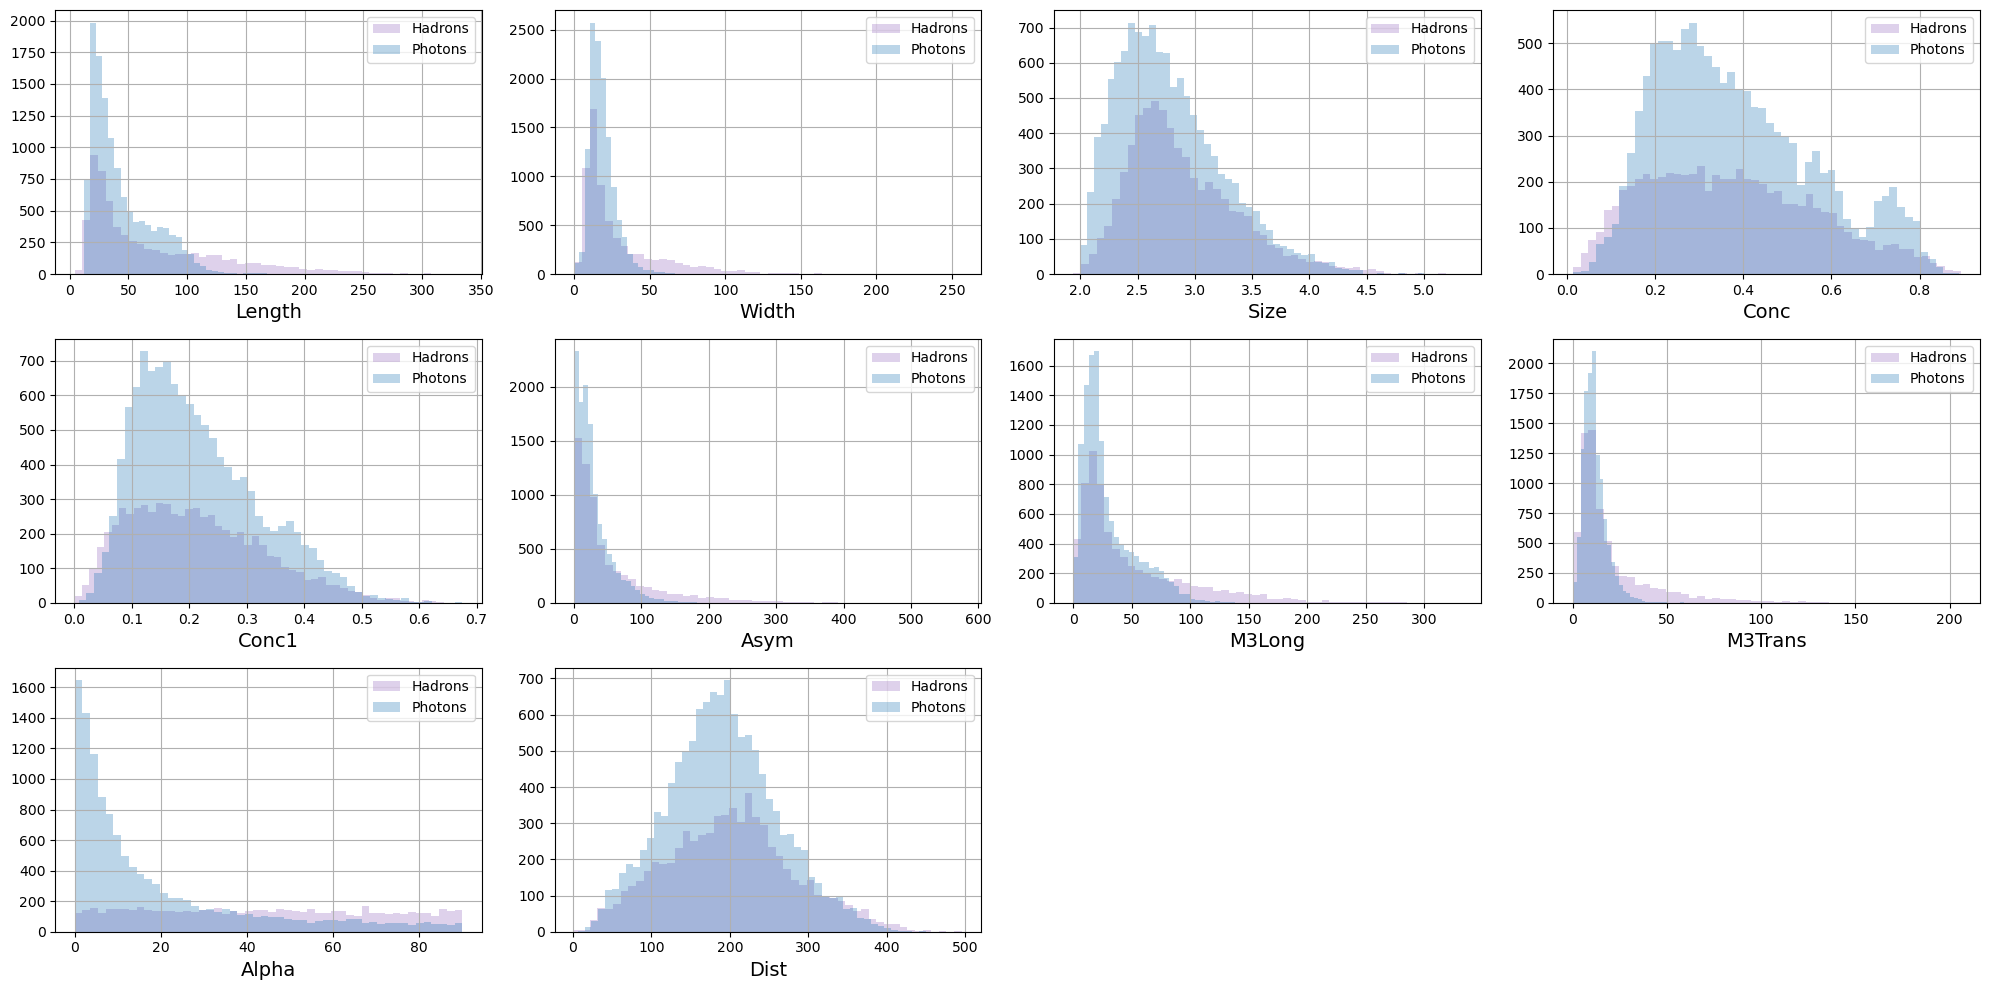

In [8]:
plot_hists(
    X[y[:, 0] == 0], X[y[:, 0] == 1], names, label1="Hadrons", label2="Photons", bins=50
)

# Предобработка данных

Из графика видим, что распределения для многих признаков имеют тяжелые хвосты. Это делает обучение генеративных моделей тяжелее. Поэтому нужно как-то преобразовать данные, чтобы убрать эти тяжелые хвосты.

# Обучающая и тестовая выборки

In [9]:
from sklearn.model_selection import train_test_split

# train / test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.5, shuffle=True, random_state=11
)

## Задание 1 (0.2 балла)

Проиллюстрируйте распределение y внутри train и test выборки.

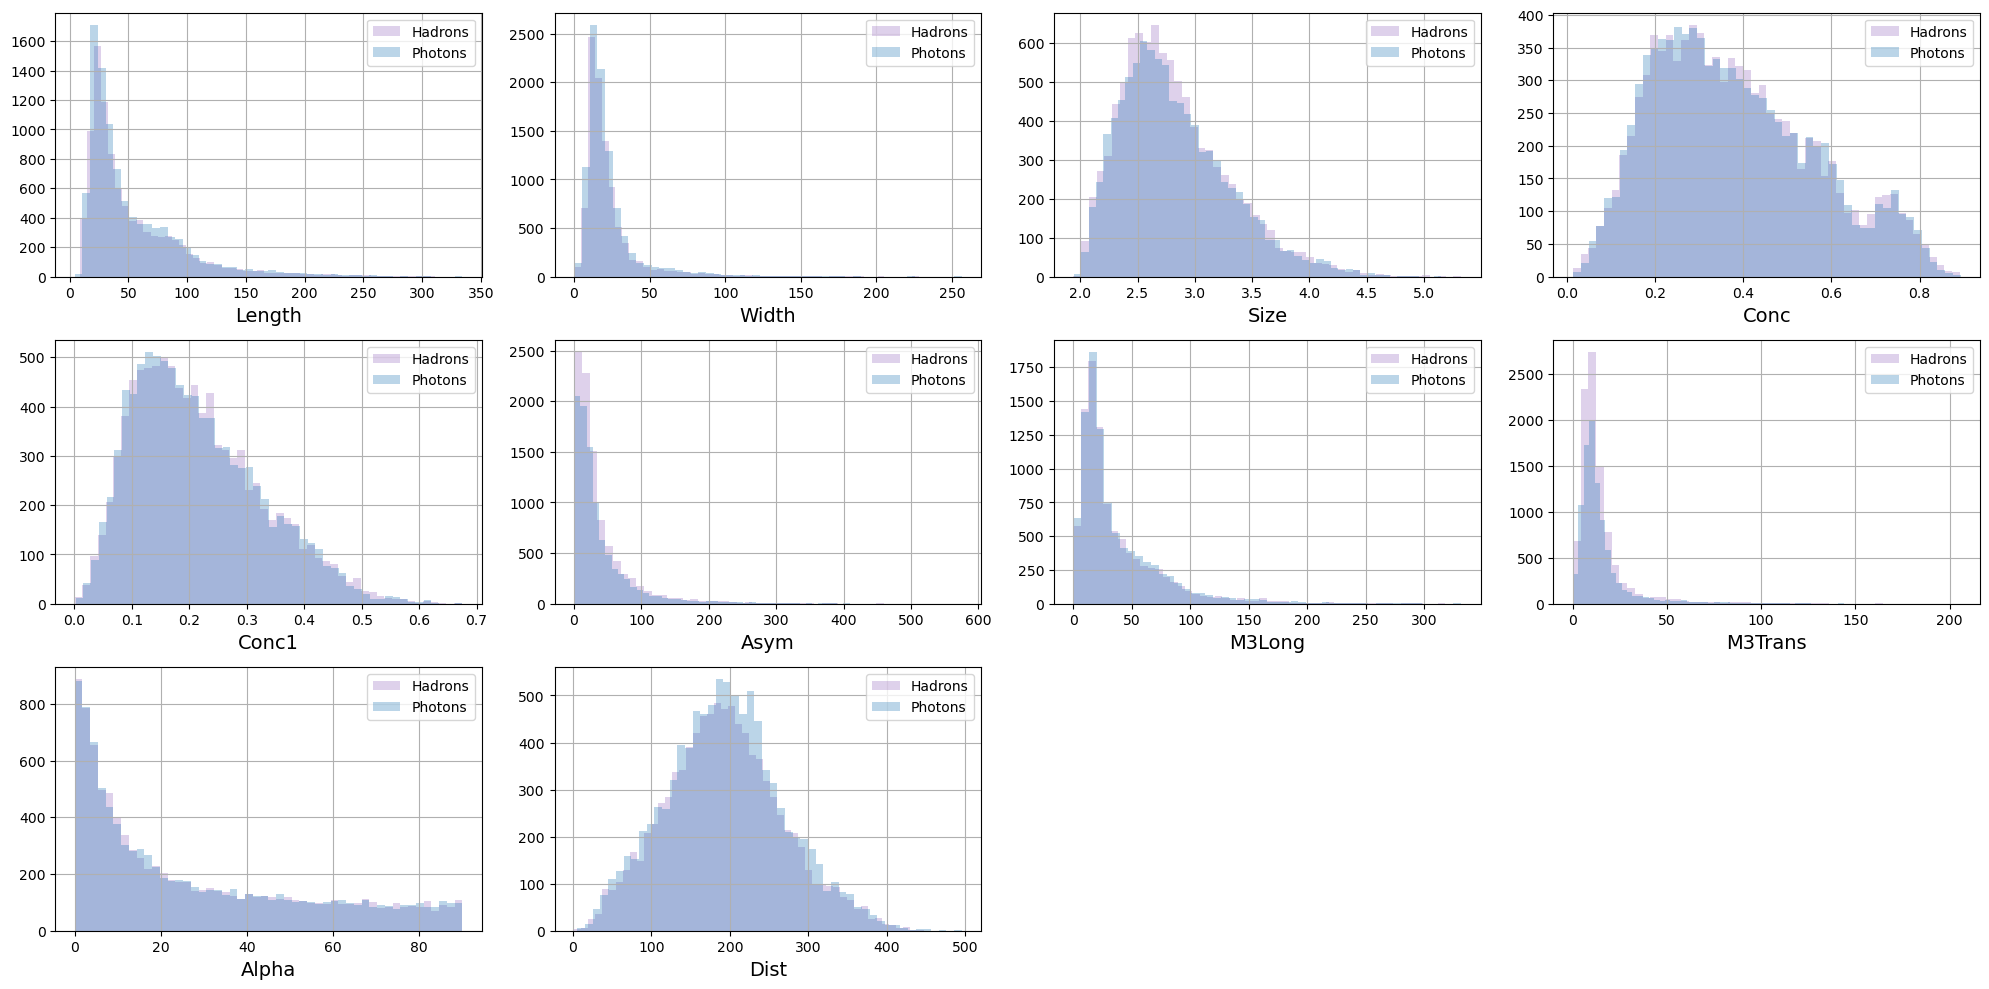

In [10]:
plot_hists(
    X_train, X_test, names, label1="Hadrons", label2="Photons", bins=50
)

- Распределение практически идентичны

## Задание 2 (0.8 балл)

Используя функцию `sklearn.preprocessing.QuantileTransformer` трансформируйте входные данные `X_train` и `X_test`. Это преобразование делает так, чтобы распределение каждого параметра было нормальным. Описание функции доступно по [ссылке](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.QuantileTransformer.html). Используйте значение параметра `output_distribution='normal'`.

In [11]:
from sklearn.preprocessing import QuantileTransformer

In [12]:
qt = QuantileTransformer(n_quantiles = 10, random_state = 42, output_distribution = 'normal')
X_train = qt.fit_transform(X_train)
X_test = qt.transform(X_test)

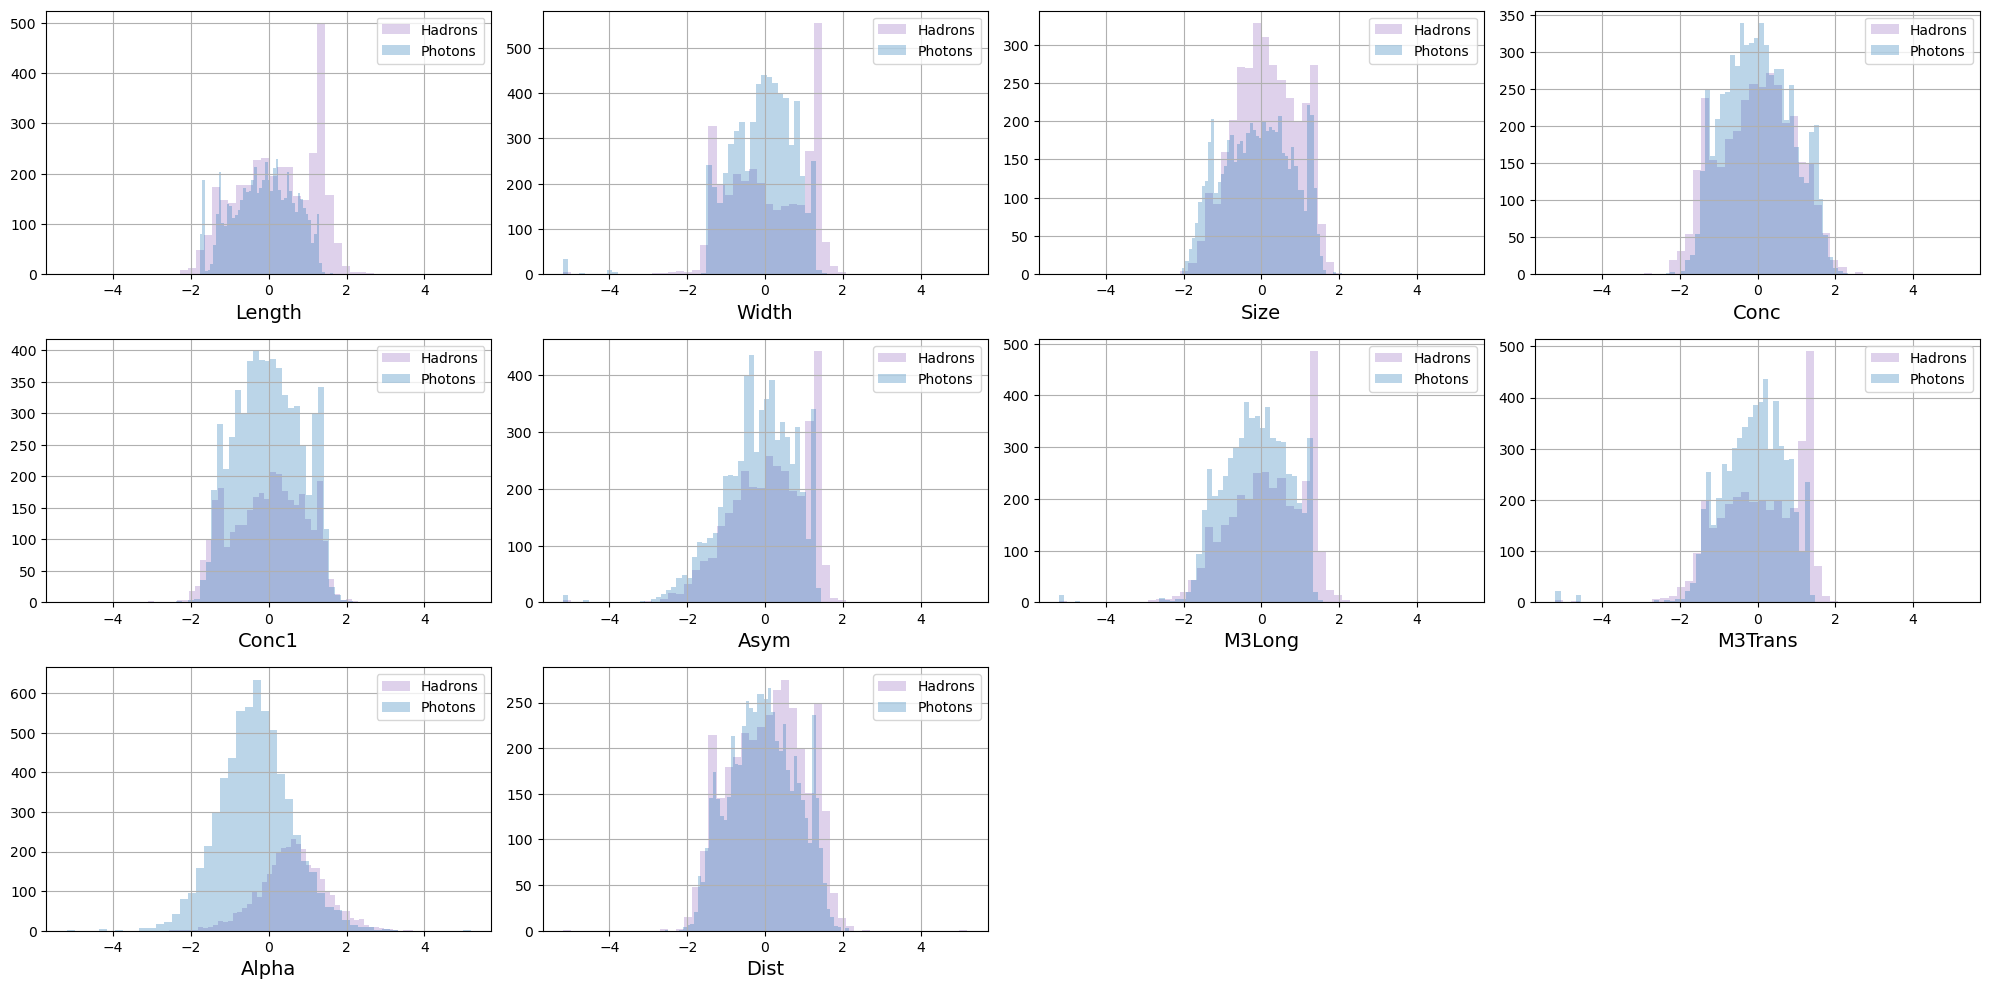

In [13]:
plot_hists(
    X_train[y_train[:, 0] == 0],
    X_train[y_train[:, 0] == 1],
    names,
    label1="Hadrons",
    label2="Photons",
    bins=50,
)

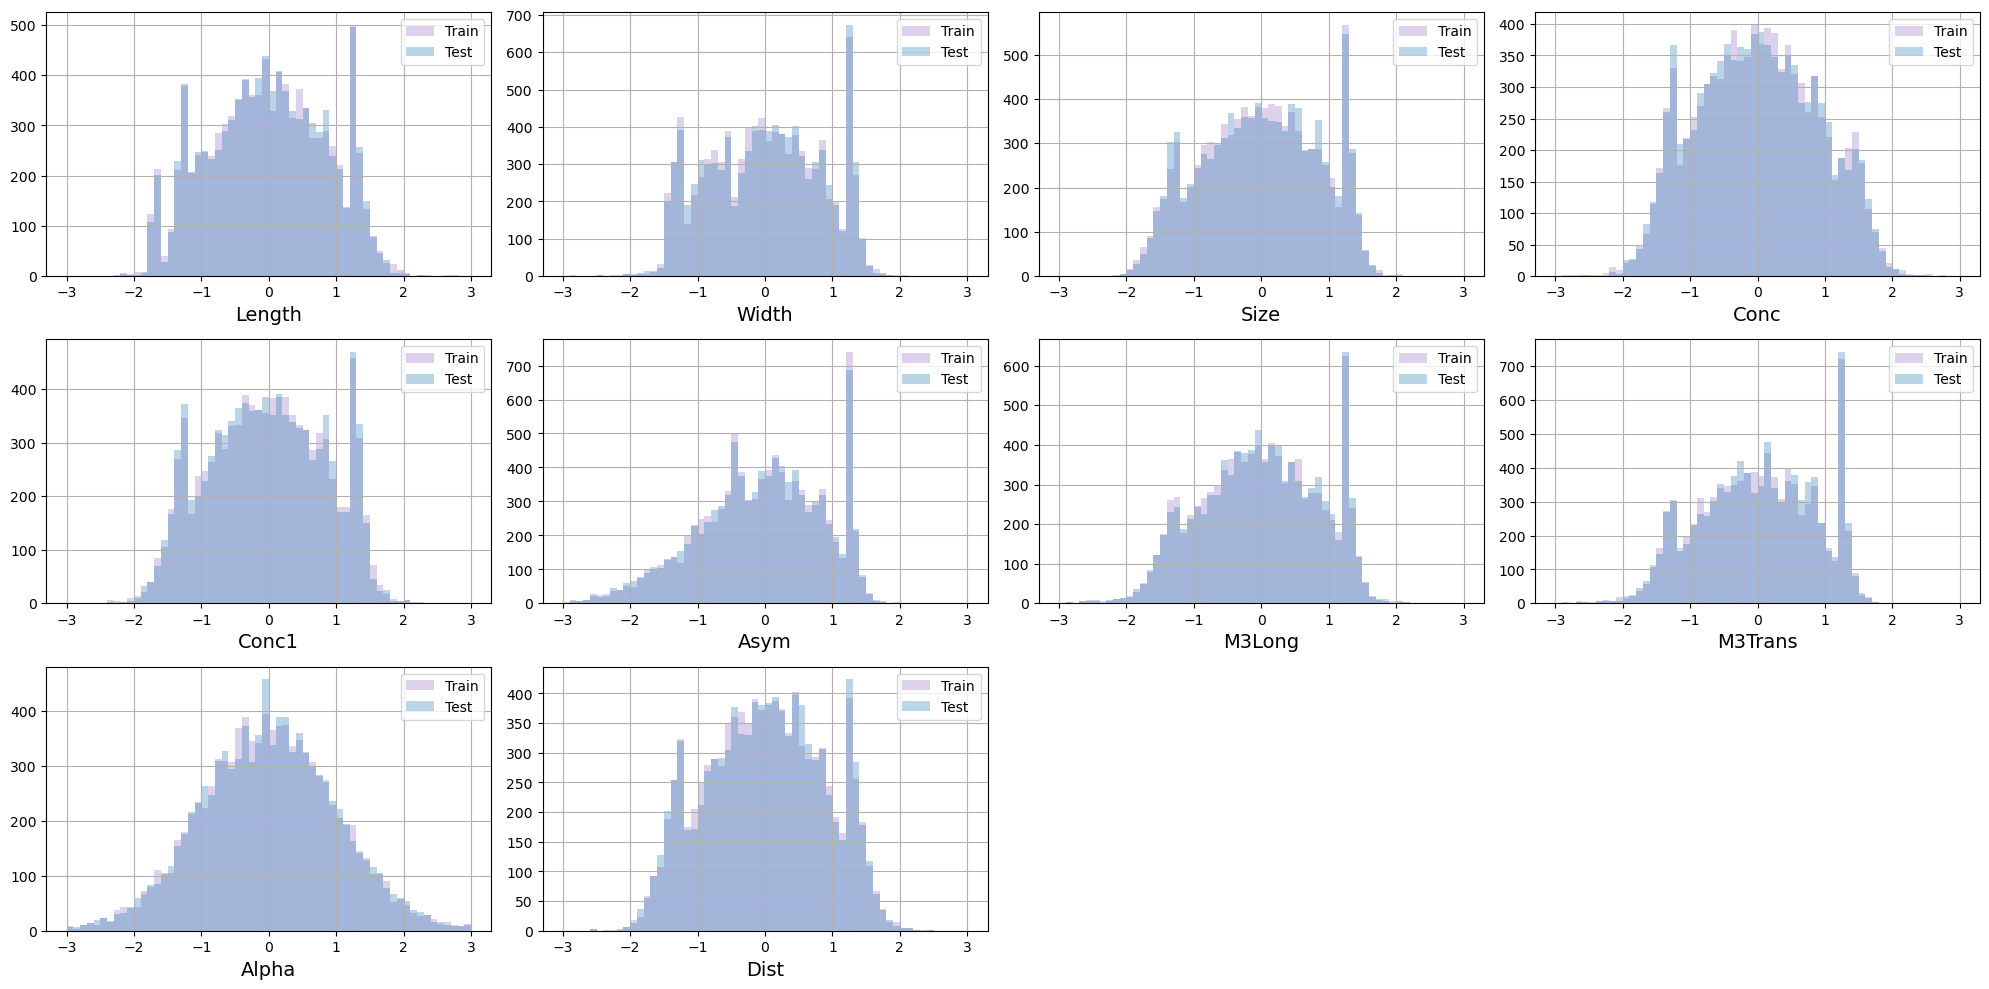

In [14]:
plot_hists(X_train, X_test, names, label1="Train", label2="Test")

# Conditional WGAN

Мы будем использовать `Conditional WGAN`, который изображен на рисунке. В качестве условия `y` мы будем использовать метку класса: **0** - адрон, **1** - фотон. Таким образом, мы будем сообщать генератору для какой частицы нужно генерировать параметры изображения. 

<center><img src="img/cgan.png" width="800"></center>

Генератор $\hat{x} = G(z, y)$ будет принимать на вход шумовой вектор $z$ и вектор условий $y$, а выдавать будет сгенерированный (фейковый) вектор параметров $\hat{x}$. 

Дискриминатор $D(x, y)$ будет принимать на вход вектор параметров $x$ и вектор условий $y$, а возвращать будет рациональное число.

Обучать `Conditional WGAN` будем с такой функцией потерь:

$$L(G, D) = -\frac{1}{n} \sum_{x_i \in X, y_i \in y} D(x_i, y_i) + -\frac{1}{n} \sum_{z_i \in Z, y_i \in y} D(G(z_i, y_i), y_i) \to \max_G \min_D$$

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
DEVICE

device(type='cpu')

## Задание 3 (0.75 балла)

Реализуйте нейронную сеть для генератора со следующими слоями:
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Выходной слой.

In [17]:
class Generator(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(n_inputs, 100)
        self.norm1 = nn.BatchNorm1d(100)
        self.relu = nn.ReLU()
        
        self.fc2 = nn.Linear(100, 100)
        self.norm2 = nn.BatchNorm1d(100)
        self.relu = nn.ReLU()

        self.fc3 = nn.Linear(100, n_outputs)


    def forward(self, z, y):
        zy = torch.cat((z, y), dim=1)
        zy = self.fc1(zy)
        zy = self.norm1(zy)
        zy = self.relu(zy)
        
        zy = self.fc2(zy)
        zy = self.norm2(zy)
        zy = self.relu(zy)
        
        zy = self.fc3(zy)
        
        return zy

## Задание 4 (0.5 балл)

Реализуйте функцию для генерации новый объектов $X$ по вектору условий $y$.

In [18]:
def generate(generator, y, latent_dim):
    noise = torch.normal(0, 1, (len(y), latent_dim))
    y = torch.tensor(y, dtype=torch.float32)

    device = next(generator.parameters()).device
    noise = noise.to(device)
    y = y.to(device)

    with torch.no_grad():
        X_fake = generator(noise, y)
        
    X_fake = X_fake.cpu().numpy()

    return X_fake

## Задание 5 (0.75 балла)

Реализуйте нейронную сеть для дискриминатора со следующими слоями:
- Полносвязный слой со 100 нейронами;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- ReLU функцию активации;
- Выходной слой.

Какая функция активации должна быть в конце работы модели и почему? А она вообще тут должна быть? Обоснуйте свой выбор.

In [19]:
class Discriminator(nn.Module):
    def __init__(self, n_inputs):
        super(Discriminator, self).__init__()

        self.fc1 = nn.Linear(n_inputs, 100)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(100, 100)
        self.relu = nn.ReLU()
        self.fc3 = nn.Linear(100, 1)

    def forward(self, x, y):
        xy = torch.cat((x, y), dim=1)
        xy = self.fc1(xy)
        xy = self.relu(xy)
        
        xy = self.fc2(xy)
        xy = self.relu(xy)
        
        xy = self.fc3(xy)
        return xy

## Задание 6 (0.5 балла)

Реализуйте функцию, которая принимала бы на вход набор сгенерированных и настоящих объектов, разбивала на train и test с учетом баланса классов (real и fake объектов), с соотношением 3 к 1, обучала модель логистической регрессии и градиентного бустинга, которые учились бы отличать настоящие объекты от фальшивых, после чего выводила бы accuracy score на отложенной выборке у обоих моделей.

Ответьте на вопрос: какое значение accuracy score нас бы удовлетворило больше всего? Почему?

- Нас удовлетворило бы значение accuracy = 1) С этим значением мы на 100% определяем класс

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor

In [21]:
def other_agent_score(X_real, y_real, X_fake, y_fake):

    log_reg = LogisticRegression()
    boosting = GradientBoostingRegressor()

    X = np.concatenate((X_real, X_fake), axis=0)
    y = np.concatenate((y_real, y_fake), axis=0)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
    
    y_train = y_train.ravel()
    y_test = y_test.ravel()

    log_reg.fit(X_train, y_train)
    boosting.fit(X_train, y_train)

    log_reg_score = log_reg.score(X_test, y_test)
    boosting_score = boosting.score(X_test, y_test)

    print("Linear regression score: " + str(log_reg_score))
    print("Boosting score: " + str(boosting_score))

## Задание 7 (1.5 балла)

Реализуйте класс для обучения генеративной модели.

- Уточнение 1: Нужно ограничивать веса дискриминатора. Для этого используйте `p.data.clamp_(-0.01, 0.01)`, где `p` веса дискриминатора. Зачем это делать можно посмотреть в оригинальной статье <https://arxiv.org/pdf/1701.07875.pdf>.
- Подсказка 1: `n_critic` - число итераций обучения дискриминатора на одну итерацию обучения генератора.
- Подсказка 2: Используйте `X_tensor = torch.tensor(X_numpy, dtype=torch.float, device=DEVICE)` для перевода numpy в тензор.

In [22]:
class Fitter(object):
    def __init__(
        self,
        generator,
        discriminator,
        batch_size=32,
        n_epochs=10,
        latent_dim=1,
        lr=0.0001,
        n_critic=5,
    ):

        self.generator = generator
        self.discriminator = discriminator
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.n_critic = n_critic

        self.opt_gen = torch.optim.RMSprop(self.generator.parameters(), lr=self.lr)
        self.opt_disc = torch.optim.RMSprop(self.discriminator.parameters(), lr=self.lr)

        self.generator.to(DEVICE)
        self.discriminator.to(DEVICE)

    def fit(self, X, y):

        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)
        dataset_real = TensorDataset(X_real, y_cond)

        self.generator.train(True)
        self.discriminator.train(True)

        self.loss_history = []

        for epoch in range(self.n_epochs):
            for i, (real_batch, cond_batch) in enumerate(
                DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)
            ):

                for _ in range(self.n_critic):
                    self.opt_disc.zero_grad()

                    # real data training
                    real_data = real_batch.to(DEVICE)
                    real_cond = cond_batch.to(DEVICE)
                    real_pred = self.discriminator(real_data, real_cond)
                    real_loss = -torch.mean(real_pred)

                    # fake data generation
                    z = torch.randn(real_batch.size(0), self.latent_dim, device=DEVICE)
                    fake_data = self.generator(z, real_cond).detach()
                    fake_pred = self.discriminator(fake_data, real_cond)
                    fake_loss = torch.mean(fake_pred)

                    # discriminator update
                    disc_loss = real_loss + fake_loss
                    disc_loss.backward()
                    self.opt_disc.step()

                    # weight clipping for discriminator
                    for p in self.discriminator.parameters():
                        p.data.clamp_(-0.01, 0.01)

                # generator training
                self.opt_gen.zero_grad()

                # fake data generation
                z = torch.randn(real_batch.size(0), self.latent_dim, device=DEVICE)
                fake_data = self.generator(z, real_cond)
                fake_pred = self.discriminator(fake_data, real_cond)
                gen_loss = -torch.mean(fake_pred)

                # generator update
                gen_loss.backward()
                self.opt_gen.step()

            # lLoss logging
            Z_noise = torch.randn(len(X_real), self.latent_dim, device=DEVICE)
            X_fake = self.generator(Z_noise, y_cond)
            loss_epoch = torch.mean(self.discriminator(X_real, y_cond)) - torch.mean(
                self.discriminator(X_fake, y_cond)
            )
            self.loss_history.append(loss_epoch.item())

            # sample 1000 objects
            sample_indices = torch.randperm(len(X_train))[:1000]
            X_real_sample = X_train[sample_indices]
            y_real_sample = y_train[sample_indices]
            Z_noise = torch.randn(1000, self.latent_dim, device=DEVICE)
            y_fake_sample = torch.ones(1000, 1, device=DEVICE)
            X_fake_sample = self.generator(Z_noise, y_fake_sample[:1000]).detach().cpu().numpy()

            # evaluate
            other_agent_score(X_real_sample, y_real_sample, X_fake_sample, np.zeros((1000, 1)))

            print(f"Epoch {epoch+1}/{self.n_epochs}, Loss: {loss_epoch.item()}")

        self.generator.train(False)
        self.discriminator.train(False)


## Обучение
Обучим модель на данных.

In [23]:
%%time
latent_dim = 10
generator = Generator(n_inputs=latent_dim + y.shape[1], n_outputs=X_train.shape[1])
discriminator = Discriminator(n_inputs=X_train.shape[1] + y.shape[1])

fitter = Fitter(
    generator,
    discriminator,
    batch_size=50,
    n_epochs=100,
    latent_dim=latent_dim,
    lr=0.0001,
    n_critic=5,
)
fitter.fit(X_train, y_train)

Linear regression score: 0.654
Boosting score: 0.24075807589762477
Epoch 1/100, Loss: 0.00029964931309223175
Linear regression score: 0.71
Boosting score: 0.29279935399328794
Epoch 2/100, Loss: -6.126705557107925e-05
Linear regression score: 0.684
Boosting score: 0.24160440126323213
Epoch 3/100, Loss: 1.3431534171104431e-05
Linear regression score: 0.658
Boosting score: 0.2460299400280015
Epoch 4/100, Loss: 3.893859684467316e-05
Linear regression score: 0.666
Boosting score: 0.25642091653245824
Epoch 5/100, Loss: 0.00014507491141557693
Linear regression score: 0.662
Boosting score: 0.240777155727406
Epoch 6/100, Loss: 0.00023955758661031723
Linear regression score: 0.69
Boosting score: 0.25137977467379835
Epoch 7/100, Loss: 0.00014834385365247726
Linear regression score: 0.69
Boosting score: 0.20793183250041458
Epoch 8/100, Loss: 7.373373955488205e-05
Linear regression score: 0.694
Boosting score: 0.2784186701824276
Epoch 9/100, Loss: 7.866881787776947e-05
Linear regression score: 0.70

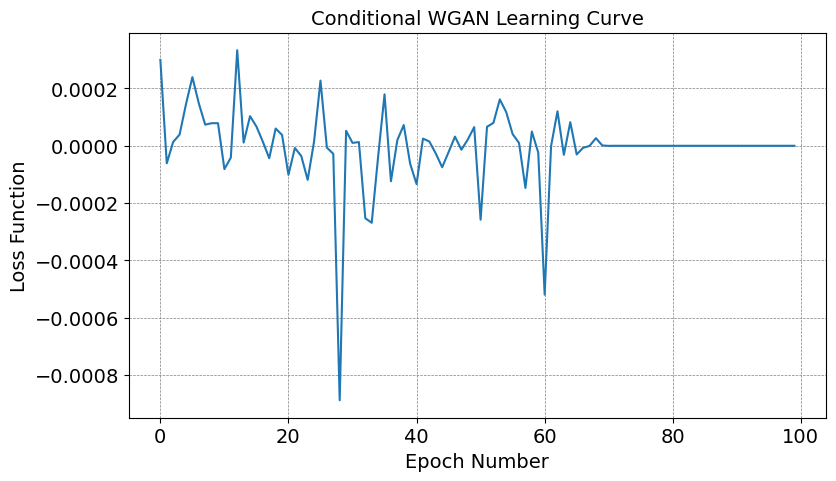

In [24]:
# WGAN learning curve
plt.figure(figsize=(9, 5))
plt.plot(fitter.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Conditional WGAN Learning Curve", size=14)
plt.grid(True, linestyle="--", linewidth=0.5, color="0.5")
plt.show()

## Задание 8 (0.5 балла)

Теперь сгенерируем фейковые матрицы `X_fake_train` и `X_fake_test`. Сравним их с матрицами реальных объектов `X_train` и `X_test`. Перед сравнением результатов сделайте обратное квантильное преобразование с помощью трансформера, который вы обучили в задании 2.

In [25]:
X_fake_train = generate(fitter.generator, y_train, latent_dim = 10)

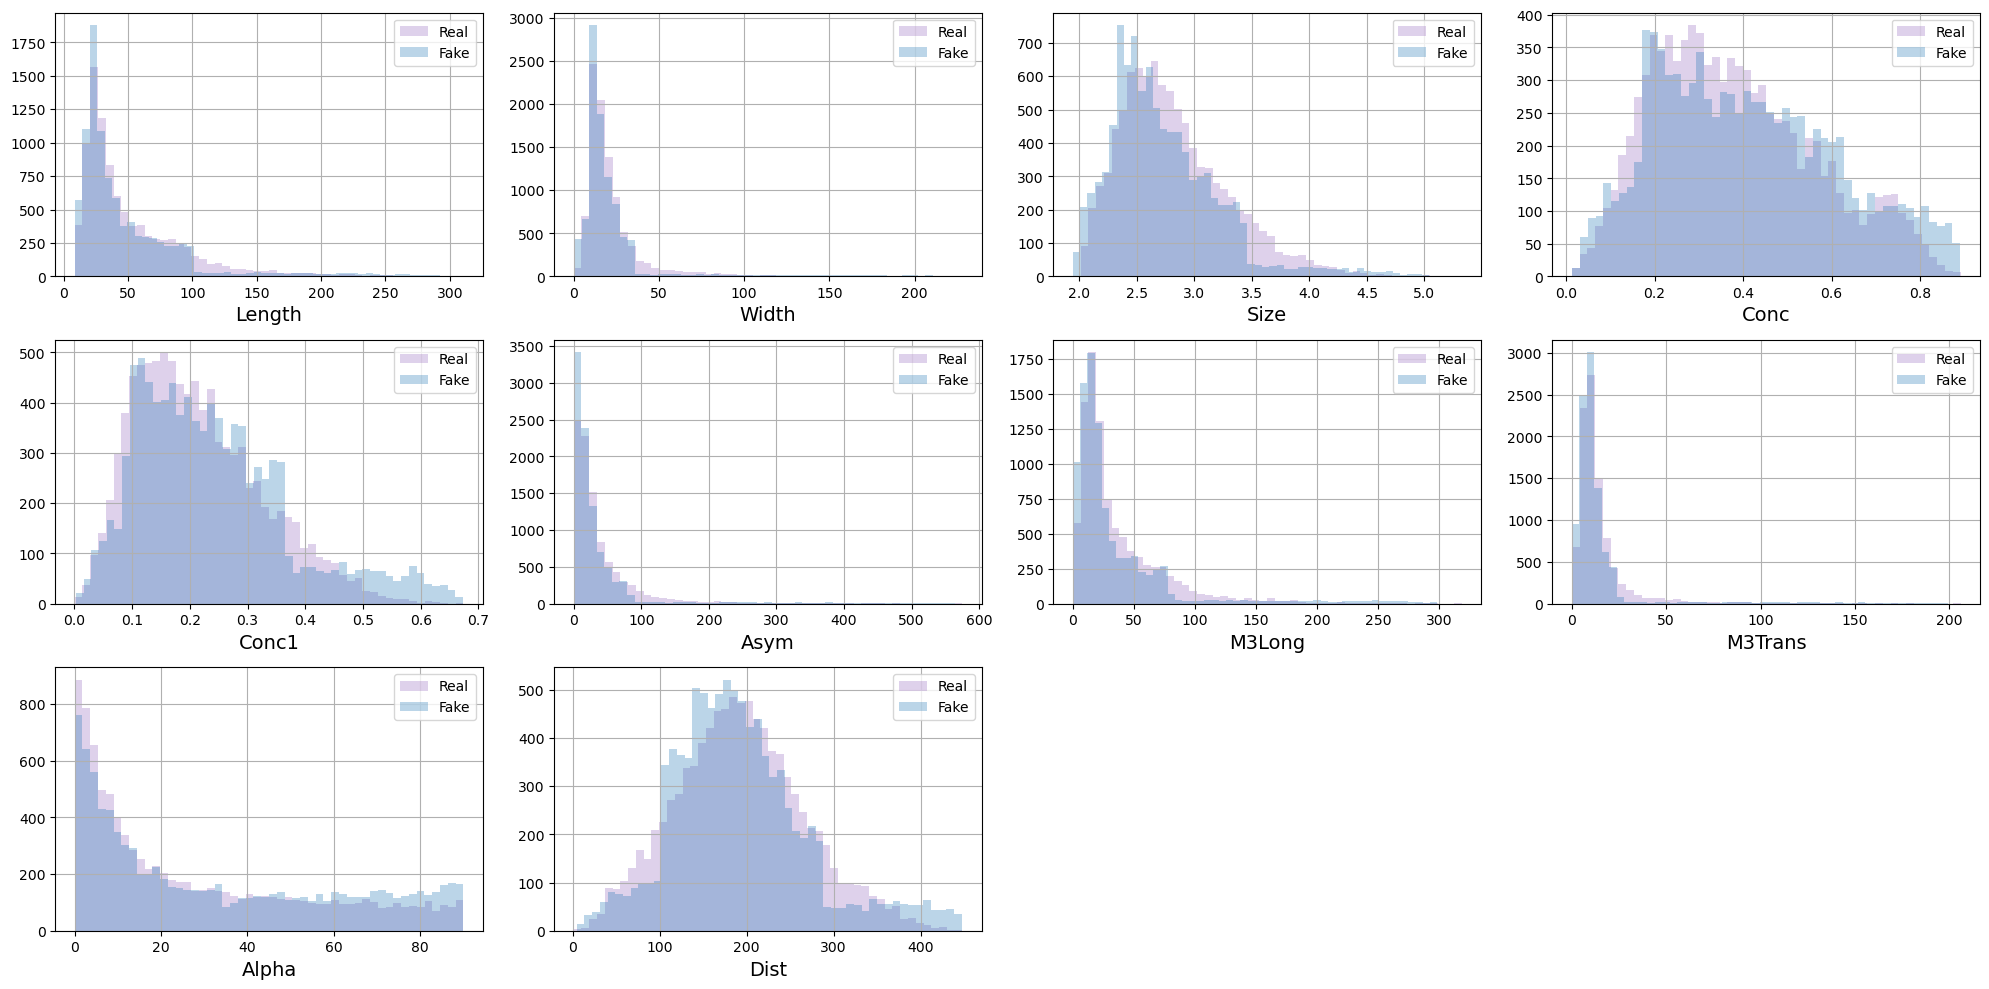

In [26]:
plot_hists(qt.inverse_transform(X_train), qt.inverse_transform(X_fake_train), names, label1="Real", label2="Fake", bins=50)

In [27]:
X_fake_test = generate(fitter.generator, y_test, latent_dim = 10)

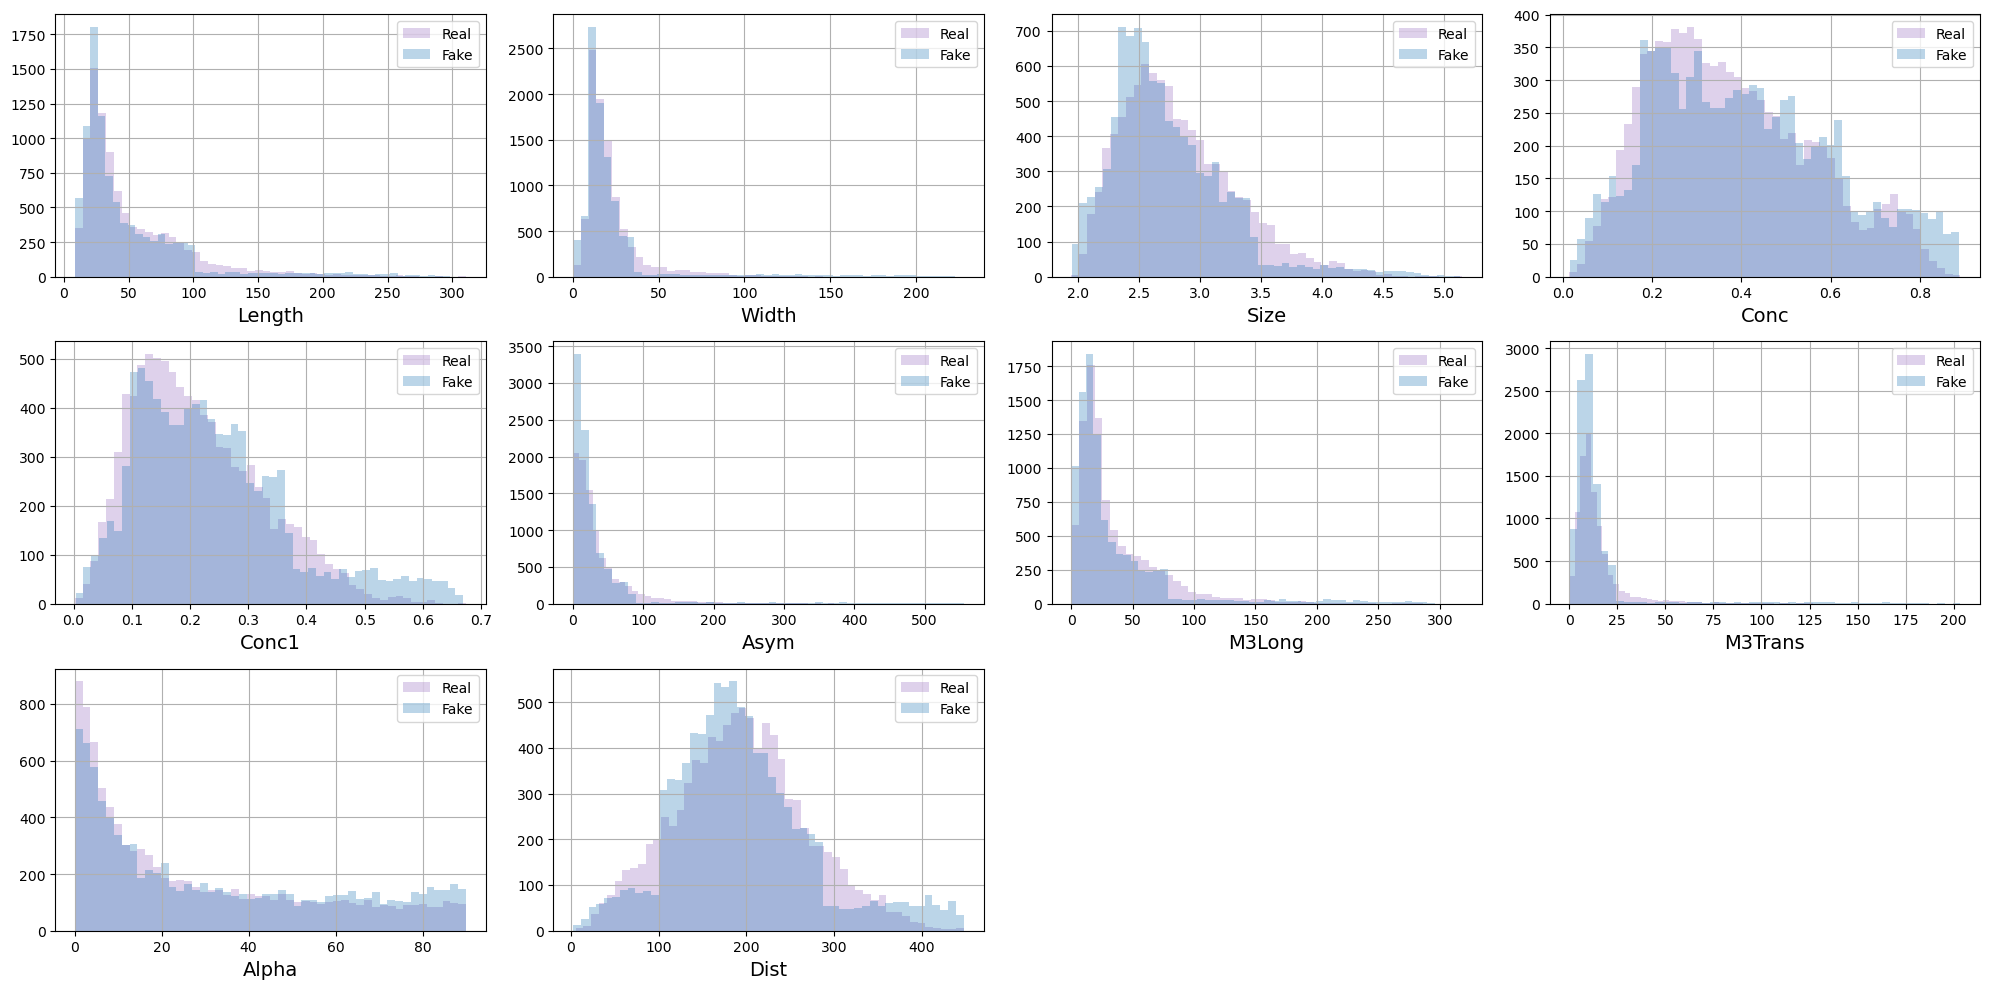

In [28]:
plot_hists(qt.inverse_transform(X_test), qt.inverse_transform(X_fake_test), names, label1="Real", label2="Fake", bins=50)

## Вывод: 
Визуально мы видим сходство реальных и фейковых данных. Однако это только проекции 10-мерных объектов на одну ось.

# Измерение качества генерации

<center><img src="img/clf.png" width="600"></center>

Измерим сходство распределений классификатором.

In [29]:
# собираем реальный и фейковые матрицы в одну
XX_train = np.concatenate((X_fake_train, X_train), axis=0)
XX_test = np.concatenate((X_fake_test, X_test), axis=0)

yy_train = np.array([0] * len(X_fake_train) + [1] * len(X_train))
yy_test = np.array([0] * len(X_fake_test) + [1] * len(X_test))

In [30]:
from sklearn.ensemble import GradientBoostingClassifier

# обучаем классификатор
clf = GradientBoostingClassifier()
clf.fit(XX_train, yy_train)

# получаем прогнозы
yy_test_proba = clf.predict_proba(XX_test)[:, 1]

In [31]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(yy_test, yy_test_proba)
print("ROC AUC = ", auc)

ROC AUC =  0.8259194759846573


## Задание 9 (0.5 балла)

Опишите ваш эксперимент. Как вы оцениваете полученные результаты? Как вы думаете, какое значение ROC AUC нас удовлетворяет больше всего? Почему?


- Я провел эксперимент, в котором попытался сгенерировать такие данные X_fake, которые будут плохо отличимы от оригинельных данных X. В результате, мне удалось получить нулевой лосс. Однако при обучении clf я получил ROC AUC ~0.8. Это значит, что модель неплохо отличает данные. Идеальным был бы ROC AUC = 0.5 (данные неотличимы). Таким образом, результат эксперимента - удовлетворительно

## Диффузионные модели.

Давайте теперь проведем такой же экперимент с простой диффузионной моделью.

## Задание 10 (0.5 балла)

Реализуйте фукнцию из семинара для зашумления данных, адаптировав ее под наш тип данных.

In [52]:
def corrupt(x: torch.Tensor, amount: torch.Tensor) -> torch.Tensor:
    
    noise = torch.rand_like(x)
    amount = amount.view(-1, 1)
    return x * (1 - amount) + noise * amount

## Добавим sсheduler, он пригодится вам при обучении модели

In [33]:
import torch
import torchvision
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt
from torch import nn
from torch.utils.data import DataLoader
from tqdm.auto import tqdm


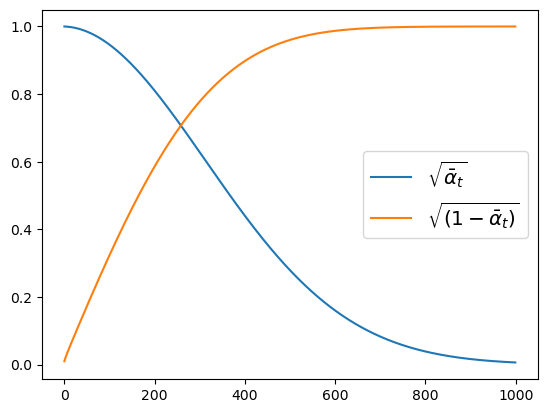

In [34]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
plt.plot(
    noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$"
)
plt.plot(
    (1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5,
    label=r"$\sqrt{(1 - \bar{\alpha}_t)}$",
)
plt.legend(fontsize="x-large")

## Задание 11 (0.5 балла)

Реализуйте нейронную сеть. В качетсве архитектуры можете взять модель генератора. В процессе экспериментов попробуйте изменять архитектуру модели для улучшения качества сгенерированных объектов (Кстати, как вы будете качество измерять?). 

- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Выходной слой.

In [40]:
class DiffusionGenerator(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(DiffusionGenerator, self).__init__()
        self.fc1 = nn.Linear(n_inputs, 100)
        self.bn1 = nn.BatchNorm1d(100)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(100, 100)
        self.bn2 = nn.BatchNorm1d(100)
        self.fc3 = nn.Linear(100, n_outputs)

    def forward(self, z, y):
        zy = torch.cat((z, y), dim=1)
        
        out = self.fc1(zy)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.fc3(out)

        return out

In [41]:
generator = DiffusionGenerator(n_inputs=latent_dim + y.shape[1], n_outputs=X_train.shape[1])

## Задание 12 (0.5 балла)

Напишите функцию для генерации нового объекта с помощью обученной модели.

In [53]:
def generate_with_diffusion(model, y, latent_dim, scheduler):

    X = torch.randn(y.shape[0], latent_dim, device=DEVICE) 
    y = torch.tensor(y, device=DEVICE) 
    X = X.to(torch.float32) 
    y= y.to(torch.float32)

    for t in scheduler.timesteps:
        with torch.no_grad():
            noisy_residual = model(X, y)
            prev_noisy_sample = scheduler.step(noisy_residual, t, X).prev_sample
            X = prev_noisy_sample

    return X.detach().cpu().numpy()

## Задание 13 (2 балла)

Напишите класс обучения диффузионной модели и обучите модель, после чего опишите полученные результаты. В качестве подсказки - опирайтесь на семинар по диффузионным моделям. Вы можете изменять некоторые части кода для вашего удобства, но оставляйте в таком случаи комментарии, пожалуйста.

In [54]:
class DiffusionFitter(object):
    def __init__(
        self,
        model,
        batch_size=32,
        n_epochs=10,
        latent_dim=1,
        lr=0.0001,
        n_critic=5,
    ):

        self.model = generator
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.n_critic = n_critic

        self.opt_gen = torch.optim.RMSprop(self.model.parameters(), lr=self.lr)

        self.model.to(DEVICE)

    def fit(self, X, y):

        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)
        dataset_real = TensorDataset(X_real, y_cond)

        self.model.train(True)
        self.loss_history = []

        for epoch in range(self.n_epochs):
            loss_epoch = 0
            for i, (real_batch, cond_batch) in enumerate(
                DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)
            ):
                # Generating noise
                noise_amount = torch.rand(real_batch.shape[0], device=DEVICE)
                noisy_real_batch = corrupt(real_batch, noise_amount)

                pred = self.model(noisy_real_batch, cond_batch)
                loss = nn.MSELoss()(real_batch, pred)

                # Training optimizer
                self.opt_gen.zero_grad()
                loss.backward()
                self.opt_gen.step()

                loss_epoch += loss.item()

            loss_epoch /= len(DataLoader(dataset_real, batch_size=self.batch_size))
            self.loss_history.append(loss_epoch)
            print(f'epoch {epoch} loss_epoch {loss_epoch}')

            # sampling 1000 objects

            indices = torch.randperm(len(X_real))[:1000]
            X_real_sample = X_real[indices]
            y_real_sample = torch.ones(1000, 1, device=DEVICE).ravel() 

            X_fake_sample = self.model(torch.randn(1000, self.latent_dim, device=DEVICE), y_cond[indices])
            y_fake_sample = torch.zeros(1000, 1, device=DEVICE).ravel() 

            other_agent_score(X_real_sample.detach().numpy(), y_real_sample, X_fake_sample.detach().numpy(), y_fake_sample)
            print(f"Epoch {epoch+1}/{self.n_epochs}, Loss: {loss_epoch}")

        self.model.train(False)

In [44]:
%%time
latent_dim = 10
model = DiffusionGenerator(n_inputs=latent_dim + y.shape[1], n_outputs=X_train.shape[1])

diffusionFitter = DiffusionFitter(
    model,
    batch_size=50,
    n_epochs=100,
    latent_dim=latent_dim,
    lr=0.0001,
    n_critic=5,
)
diffusionFitter.fit(X_train, y_train)

epoch 0 loss_epoch 0.3939943415020149
Linear regression score: 0.488
Boosting score: 0.4589458157371563
Epoch 1/100, Loss: 0.3939943415020149
epoch 1 loss_epoch 0.27058824202465137
Linear regression score: 0.568
Boosting score: 0.3051574500542287
Epoch 2/100, Loss: 0.27058824202465137
epoch 2 loss_epoch 0.25949585047691903
Linear regression score: 0.48
Boosting score: 0.29898769933713354
Epoch 3/100, Loss: 0.25949585047691903
epoch 3 loss_epoch 0.24768384666967141
Linear regression score: 0.448
Boosting score: 0.24045873755552083
Epoch 4/100, Loss: 0.24768384666967141
epoch 4 loss_epoch 0.2370207318304721
Linear regression score: 0.474
Boosting score: 0.22407721043922357
Epoch 5/100, Loss: 0.2370207318304721
epoch 5 loss_epoch 0.2446322826502835
Linear regression score: 0.478
Boosting score: 0.24936644841472955
Epoch 6/100, Loss: 0.2446322826502835
epoch 6 loss_epoch 0.23723401449113615
Linear regression score: 0.498
Boosting score: 0.26001641077885485
Epoch 7/100, Loss: 0.237234014491

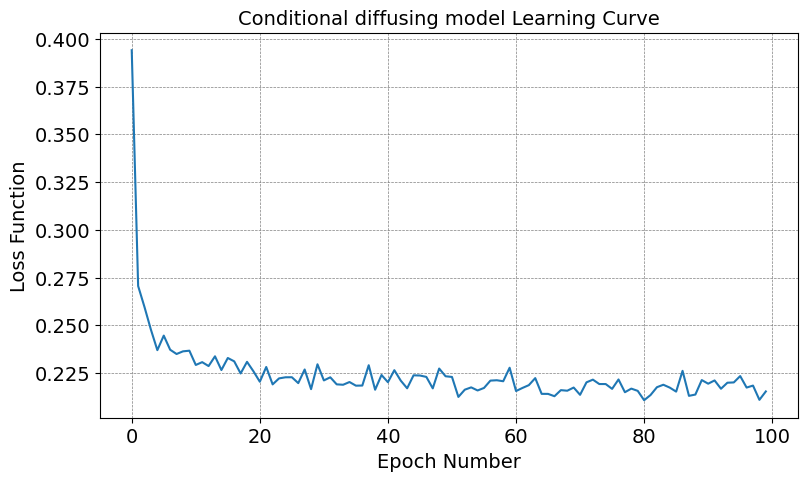

In [45]:
# diffusion learning curve
plt.figure(figsize=(9, 5))
plt.plot(diffusionFitter.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Conditional diffusing model Learning Curve", size=14)
plt.grid(True, linestyle="--", linewidth=0.5, color="0.5")
plt.show()

## Задание 14 (0.5 балла)
По аналогии с прошлым экспериментом с GAN моделью сгенерируйте выборку фейковых объектов равную размеру тестовой выборки и обучите градиентный бустинг. Обучите модель отличать реальные объекты от фейковых, после чего расчитайте метрики ROC-AUC и accuracy score. Какие получились результаты? Как вы их оцениваете? А в сравнении с GAN моделью?

In [46]:
generate_with_diffusion(diffusionFitter.model, y_train, latent_dim, noise_scheduler).shape

(9510, 10)

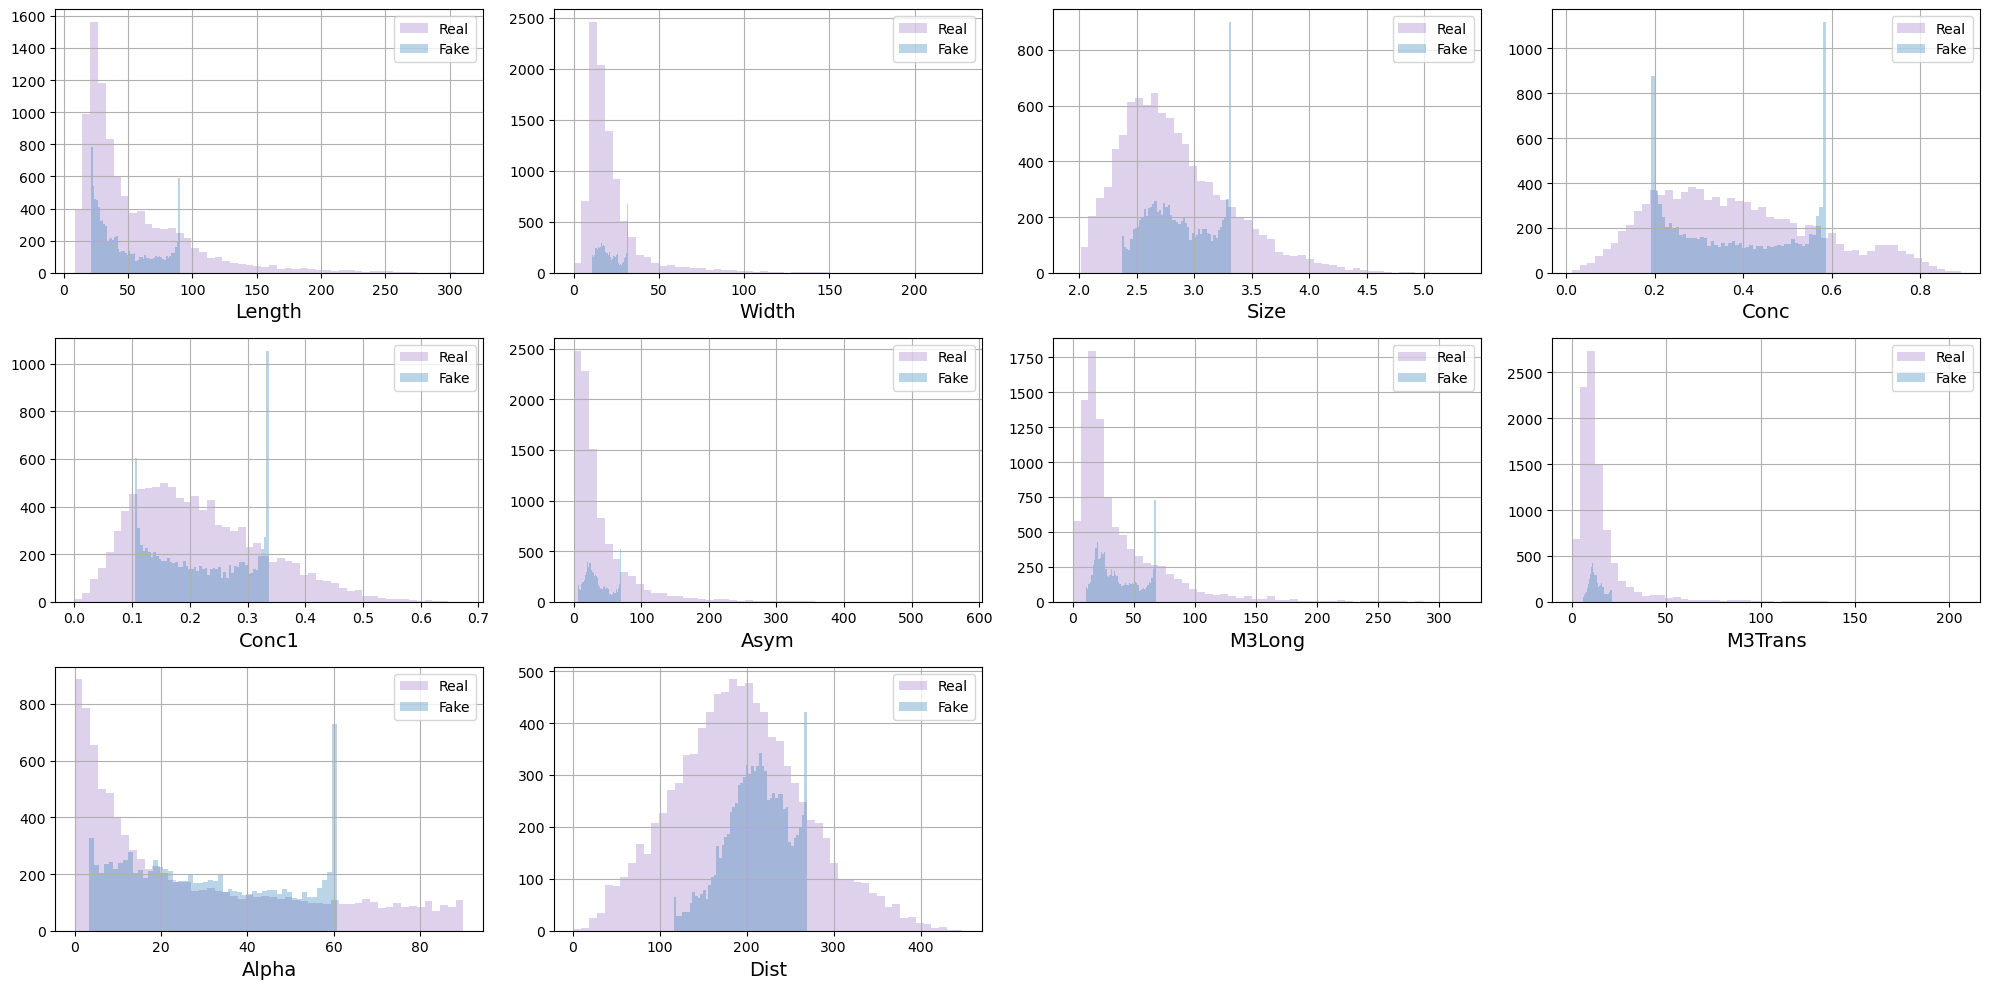

In [55]:
X_fake_train = generate_with_diffusion(diffusionFitter.model, y_train, latent_dim, noise_scheduler)
plot_hists(qt.inverse_transform(X_train), qt.inverse_transform(X_fake_train), names, label1="Real", label2="Fake", bins=50)

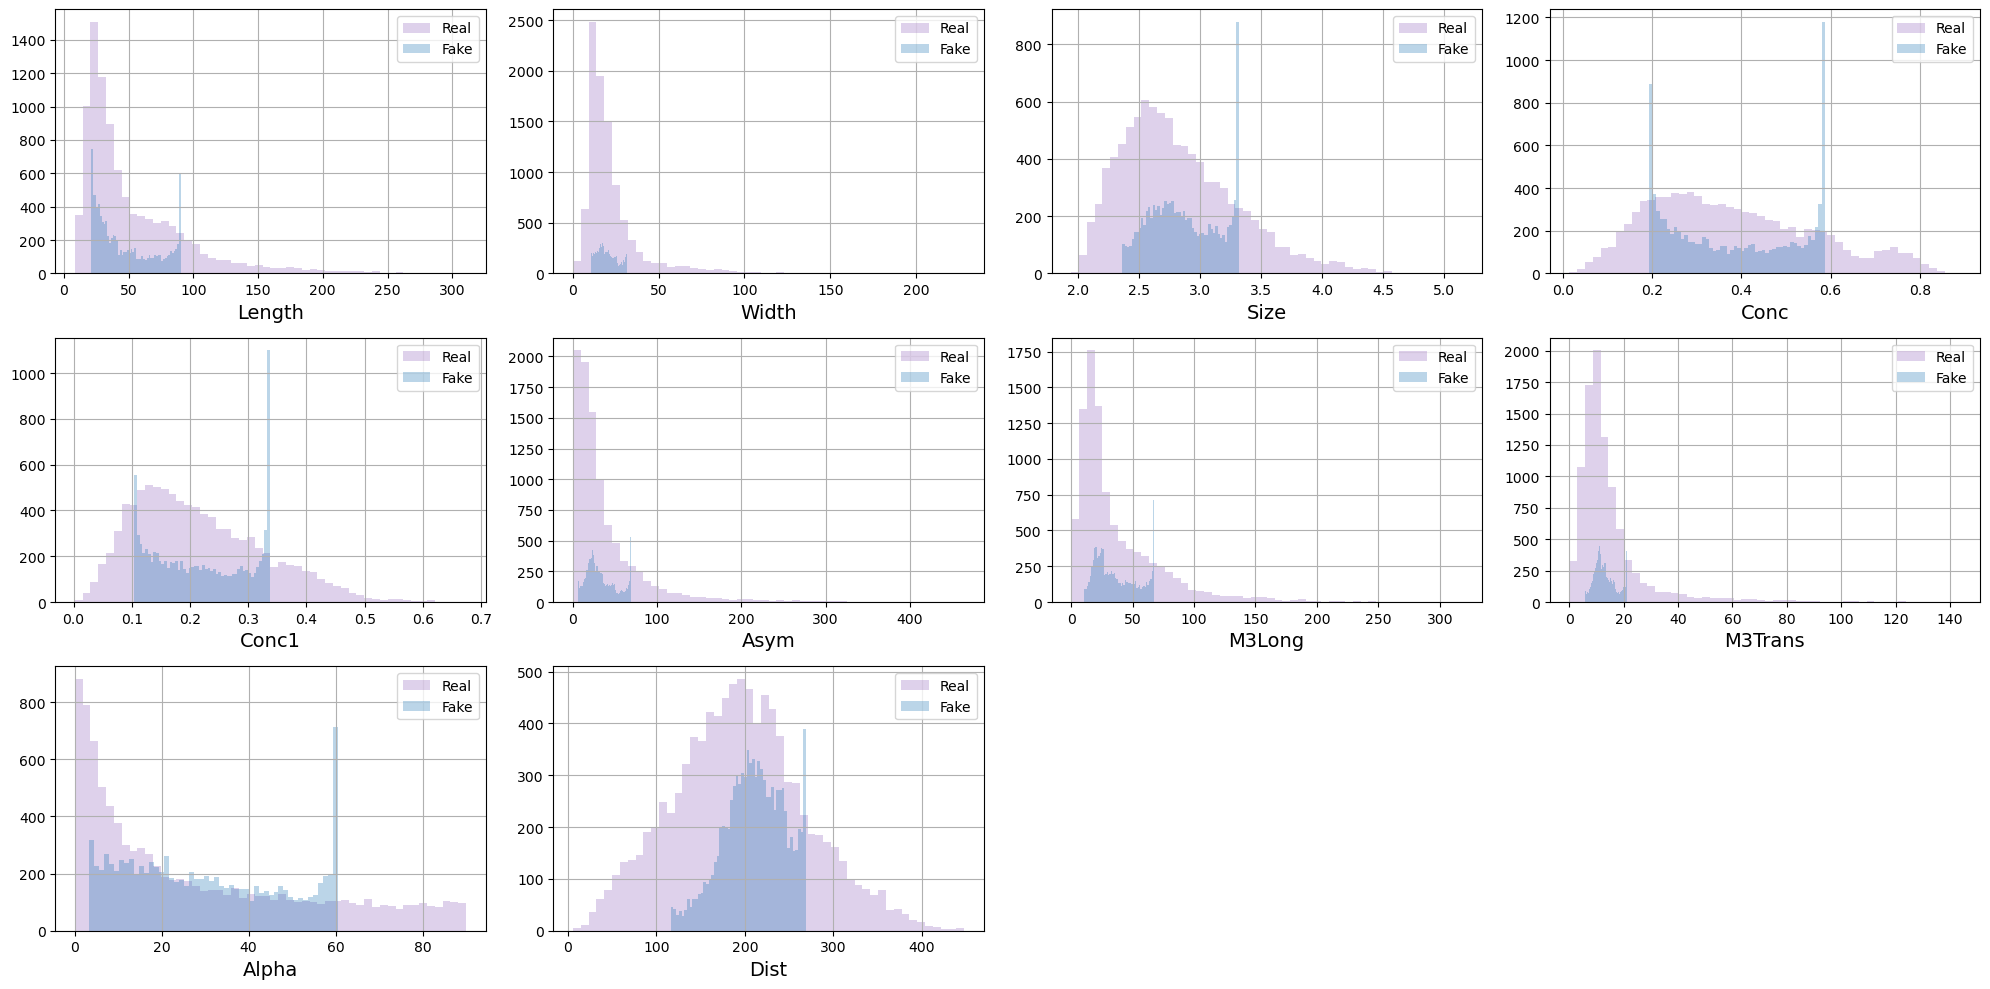

In [56]:
X_fake_test = generate_with_diffusion(diffusionFitter.model, y_test, latent_dim, noise_scheduler)
plot_hists(qt.inverse_transform(X_test), qt.inverse_transform(X_fake_test), names, label1="Real", label2="Fake", bins=50)

In [48]:
XX_train = np.concatenate((X_fake_train, X_train), axis=0)
XX_test = np.concatenate((X_fake_test, X_test), axis=0)

yy_train = np.array([0] * len(X_fake_train) + [1] * len(X_train))
yy_test = np.array([0] * len(X_fake_test) + [1] * len(X_test))

In [49]:
from sklearn.ensemble import GradientBoostingClassifier

# обучаем классификатор
clf = GradientBoostingClassifier()
clf.fit(XX_train, yy_train)

# получаем прогнозы
yy_test_proba = clf.predict_proba(XX_test)[:, 1]

In [50]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(yy_test, yy_test_proba)
print("ROC AUC = ", auc)

ROC AUC =  0.9949853991758081


- Классификатор практически идеально отличает классы. Это плохо. Модель GAN оказалась лучше

## Отзыв

Поздравляю! Вы дошли до конца. Оставьте ваш отзыв ячейкой ниже или отправьте его в канал курса, нам будет очень интересно!